In [1]:
import pandas as pd
import numpy as np

In [2]:
#read in CSVs for EAF., distance from Riparian Buf, forest age/type

path = 'Beyond450_EAF_avg_ExportTable.csv' 
Beyond450_EAF = pd.read_csv(path)
EAF = pd.read_csv("Compartment_avgEAF.csv")
dist_from_RB = pd.read_csv("Compartment_avgDistance_RB.csv")
conversion_1937_1957 = pd.read_csv("conversion_1937_1957.csv")
conversion_1957_1974 = pd.read_csv("conversion_1957_1974.csv")
conversion_1974_1996 = pd.read_csv("conversion_1974_1996.csv")
evergreen = pd.read_csv("evergreen.csv")

In [3]:
# read in CSV for overall inv. supervised data with farmland, riparian features to append former data to

invasion = pd.read_csv("Compartment_Inva_ExportTable.csv")

In [4]:
# get rid of unnecessary columns for ML

df = invasion.iloc[:,[2,5,10,20,21]]
df.head()

,Distance_Riparian_Buffer,Distance_Farmland,HID,overall_in,individual
0,136.620988,0.0,252.0,25-50%,"MIVI-3,LOJA-2,ELUM-1,ROMU-1,LISE-1,CEOR-2,BETH..."
1,-1.000000,0.0,253.0,75-100%,"MIVI-4,CEOR-4,LISE-1,LOJA-1,RUPH-1,ALJU-1"
2,137.086561,0.0,254.0,50-75%,"MIVI-4,CEOR-3,LISE-1,RUPH-1,ELUM-1,LOJA-1,ROMU-1"
3,137.086530,0.0,255.0,50-75%,"MIVI-4,CEOR-3,RUPH-3,LOJA-1,ALJU-1,CIVU-2,LISE-2"
4,137.107700,0.0,256.0,50-75%,"MIVI-3,LISE-2,CEOR-3,RUPH-2,PATO-1,LOJA-2,RUCR..."


In [5]:
# clean data from CSVs, add to df
## start with dist_from_RB 
dist_floodplain = []
EAF_list = []
for i in range(df.shape[0]): 
    #iterate over range of num rows of df
    
    HID = df.iloc[i,2] 
    #find the compartment ID for current iteration
    
    idx = dist_from_RB.index[dist_from_RB['HID'] == HID] 
    #find which index of dist_from_RB equals current HID iteration
    
    mean_distance = dist_from_RB.at[idx[0], 'MEAN_Distance_From_RB']
    #retrieves value from mean d col at row specified by idx
    
    dist_floodplain.append(mean_distance * 3.28) 
    #meters to feet formula

for i in range(df.shape[0]): #same proc for EAF
    HID = df.iloc[i,2] 
    idx = EAF.index[EAF['HID'] == HID] #find which index of overall EAF equals current HID iteration
    mean_EAF = EAF.at[idx[0], 'MEAN_EAF'] #retrieves value from mean d col at row specified by idx
    EAF_list.append(mean_EAF)

In [6]:
# fix dist_floodplain values for PW buffer HIDs

for i in range(df.shape[0]):
    if(df.iloc[i,2] >= 80 and df.iloc[i,2] <= 246):
        dist_floodplain[i] = 300
for i in range(df.shape[0]):
    if(df.iloc[i,2] <= 79):
        dist_floodplain[i] = 0

# assign riparian buffer distance to 300 meters if not within 450 ft of pw buffer
for i in range(df.shape[0]):
    if(df.iloc[i,0] == -1):
        df.iloc[i,0] = 300
        
# assign new FP dist and EAF lists to df
df = df.assign(EAF = EAF_list)
df = df.assign(Dist_Floodplain = dist_floodplain)
df.head()

,Distance_Riparian_Buffer,Distance_Farmland,HID,overall_in,individual,EAF,Dist_Floodplain
0,136.620988,0.0,252.0,25-50%,"MIVI-3,LOJA-2,ELUM-1,ROMU-1,LISE-1,CEOR-2,BETH...",38.745098,814.578296
1,300.000000,0.0,253.0,75-100%,"MIVI-4,CEOR-4,LISE-1,LOJA-1,RUPH-1,ALJU-1",58.200000,1281.677749
2,137.086561,0.0,254.0,50-75%,"MIVI-4,CEOR-3,LISE-1,RUPH-1,ELUM-1,LOJA-1,ROMU-1",42.064516,898.304107
3,137.086530,0.0,255.0,50-75%,"MIVI-4,CEOR-3,RUPH-3,LOJA-1,ALJU-1,CIVU-2,LISE-2",36.842105,646.795242
4,137.107700,0.0,256.0,50-75%,"MIVI-3,LISE-2,CEOR-3,RUPH-2,PATO-1,LOJA-2,RUCR...",35.789474,578.104646


In [7]:
# add in converted forest
con_37 = [] ## create empty list for each forest conversion
con_57 = []
con_74 = []
for i in range(df.shape[0]):
    HID = df.iloc[i,2]
    if(any(HID == conversion_1937_1957['HID'])): 
        #if the current HID exists in converted forest df
        
        idx = conversion_1937_1957['HID'] ==  HID
        con_37.append(float(conversion_1937_1957[idx]['PERCENTAGE']))
        #extract series from idx in conv forest df then convert to percentage float
        
    else:
        con_37.append(0) 
        #if tabulate overlay did not overlap with any conv forest, overlay is 0 percent
        
    if(any(HID == conversion_1957_1974['HID'])): 
        
        #same procedure for other conv forest dfs
        idx = conversion_1957_1974['HID'] ==  HID
        con_57.append(float(conversion_1957_1974[idx]['PERCENTAGE'])) 
    else:
        con_57.append(0)
    if(any(HID == conversion_1974_1996['HID'])): 
        
        #same procedure for other conv forest dfs
        idx = conversion_1974_1996['HID'] ==  HID
        con_74.append(float(conversion_1974_1996[idx]['PERCENTAGE'])) 
    else:
        con_74.append(0)
df = df.assign(conversion_1937_1957=con_37) 
#assign new column to list with percentages
df = df.assign(conversion_1957_1974=con_57)
df = df.assign(conversion_1974_1996=con_74)

In [8]:
#evergreen forest
eg = []
for i in range(df.shape[0]):
    HID = df.iloc[i,2]
    if(any(HID == evergreen['HID'])): 
        #if the current HID exists in converted forest df
        idx = evergreen['HID'] ==  HID
        eg.append(float(evergreen[idx]['PERCENTAGE'])) 
        #extract series from idx in conv forest df then convert to percentage float
    else:
        eg.append(0)
df = df.assign(evergreen_forest = eg)

In [9]:
# percentage ranges to numeric, cover class values
percentage = {'5-25%': 2, '25-50%': 3, '50-75%': 4, '75-100%': 5}
numeric_values = []

for p in df['overall_in']:
    #convert the percentage range to a numeric value
    numeric_value = percentage.get(p)
    numeric_values.append(numeric_value)
    
# add new column with numeric values
df['overall_numeric'] = numeric_values

# Create MIVI column in df

In [10]:
# create new column containing MIVI cover class

MIVI = []
for i in range(df.shape[0]):
    if 'MIVI-4' in df.iloc[i, 4]:
        MIVI.append(4)
    if 'MIVI-3' in df.iloc[i, 4]:
        MIVI.append(3)
    if 'MIVI-2' in df.iloc[i, 4]:
        MIVI.append(2)
    if 'MIVI-1' in df.iloc[i, 4]:
        MIVI.append(1)
    if not('MIVI' in df.iloc[i, 4]):
        MIVI.append(0)

In [11]:
df['MIVI'] = MIVI
idx = df["Distance_Riparian_Buffer"] == 300
tempdf = df[idx]
df.shape[1] #should have added a 13 column

13

# Check for Linear Relationships between features and target (MIVI)

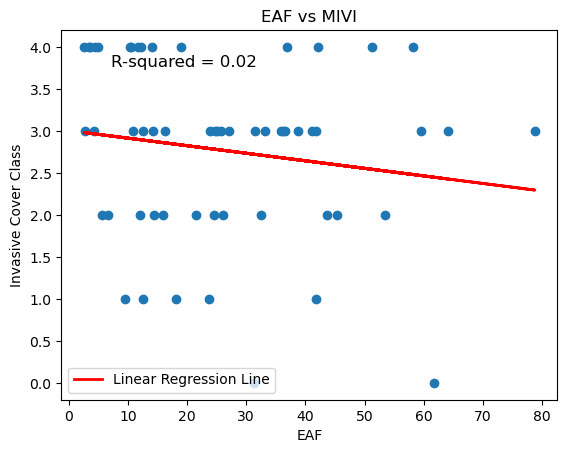

In [12]:
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

plt.scatter(df["EAF"], df["MIVI"])
# Fit a linear regression model
X = df["EAF"].values.reshape(-1, 1)
y = df["MIVI"].values
reg = LinearRegression()
reg.fit(X, y)

# Predict values using the linear regression model
y_pred = reg.predict(X)

# Plot the line of best fit
plt.plot(X, y_pred, color='red', linewidth=2, label='Linear Regression Line')

# Calculate the R-squared value
r_squared = r2_score(y, y_pred)

# Add the R-squared value to the plot
plt.annotate(f'R-squared = {r_squared:.2f}', xy=(0.1, 0.9), xycoords='axes fraction', fontsize=12)

# Add labels and a legend
plt.xlabel("EAF")
plt.ylabel("Invasive Cover Class")
plt.title("EAF vs MIVI")
plt.legend()

# Show the plot
plt.show()

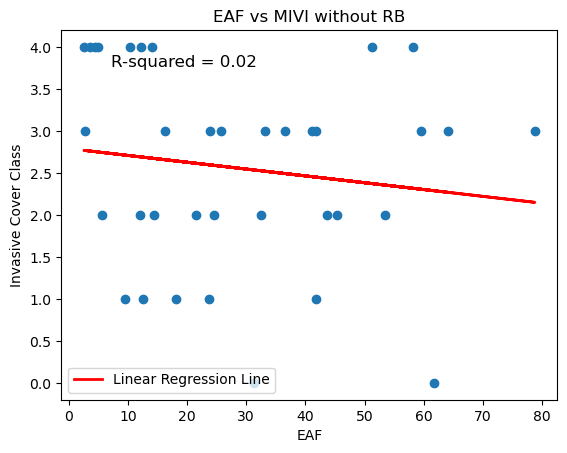

In [13]:
# now look at trend difference without riparian buffer

plt.scatter(tempdf["EAF"], tempdf["MIVI"])

X = tempdf["EAF"].values.reshape(-1, 1)
y = tempdf["MIVI"].values
reg = LinearRegression()
reg.fit(X, y)

y_pred = reg.predict(X)

plt.plot(X, y_pred, color='red', linewidth=2, label='Linear Regression Line')

r_squared = r2_score(y, y_pred)

plt.annotate(f'R-squared = {r_squared:.2f}', xy=(0.1, 0.9), xycoords='axes fraction', fontsize=12)

plt.xlabel("EAF")
plt.ylabel("Invasive Cover Class")
plt.title("EAF vs MIVI without RB")
plt.legend()

plt.show()

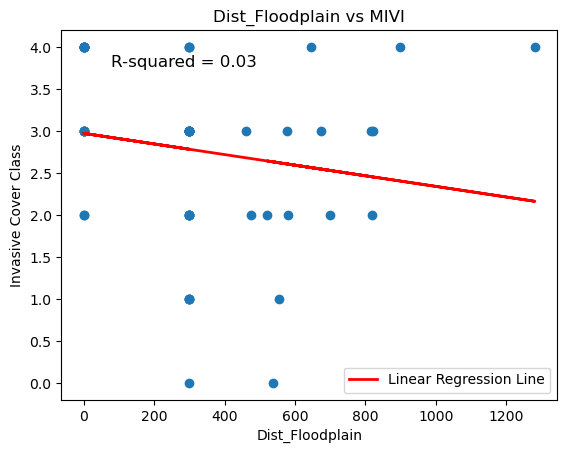

In [14]:
plt.scatter(df["Dist_Floodplain"], df["MIVI"])

X = df["Dist_Floodplain"].values.reshape(-1, 1)
y = df["MIVI"].values
reg = LinearRegression()
reg.fit(X, y)

y_pred = reg.predict(X)

plt.plot(X, y_pred, color='red', linewidth=2, label='Linear Regression Line')

r_squared = r2_score(y, y_pred)

plt.annotate(f'R-squared = {r_squared:.2f}', xy=(0.1, 0.9), xycoords='axes fraction', fontsize=12)

plt.xlabel("Dist_Floodplain")
plt.ylabel("Invasive Cover Class")
plt.title("Dist_Floodplain vs MIVI")
plt.legend()

plt.show()

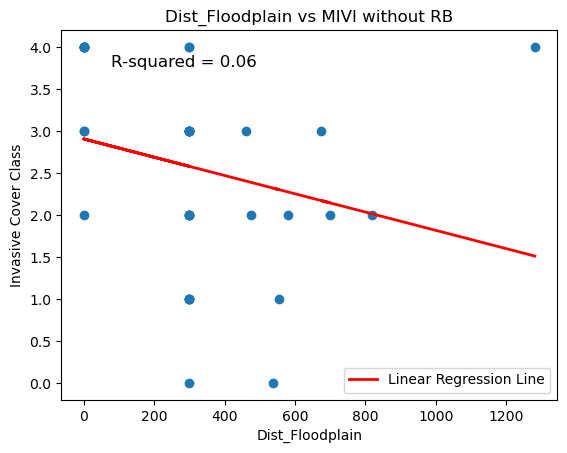

In [22]:
plt.scatter(tempdf["Dist_Floodplain"], tempdf["MIVI"])

#make features, target contain all rows except for observations along Riparian Buffer
X = tempdf["Dist_Floodplain"].values.reshape(-1, 1)
y = tempdf["MIVI"].values
reg = LinearRegression()
reg.fit(X, y)

y_pred = reg.predict(X)

plt.plot(X, y_pred, color='red', linewidth=2, label='Linear Regression Line')

r_squared = r2_score(y, y_pred)

plt.annotate(f'R-squared = {r_squared:.2f}', xy=(0.1, 0.9), xycoords='axes fraction', fontsize=12)

plt.xlabel("Dist_Floodplain")
plt.ylabel("Invasive Cover Class")
plt.title("Dist_Floodplain vs MIVI without RB")
plt.legend()

plt.show()

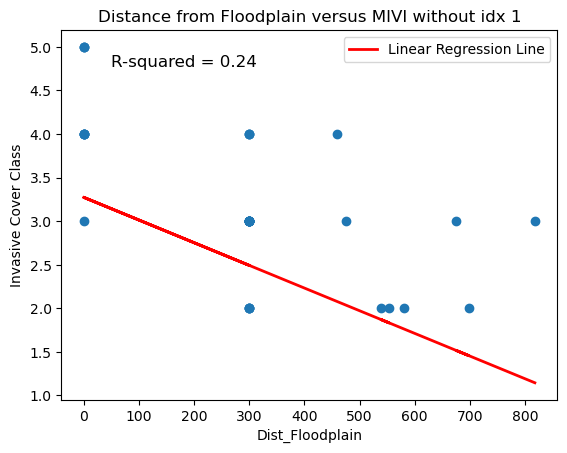

In [18]:
#get rid of outlier far from floodplain

idx = tempdf["Dist_Floodplain"] > 1200 
plt.scatter(tempdf.drop(tempdf[idx].index)["Dist_Floodplain"], tempdf.drop(tempdf[idx].index)["overall_numeric"])
# Fit a linear regression model
X = tempdf.drop(tempdf[idx].index)["Dist_Floodplain"].values.reshape(-1, 1)
y = tempdf.drop(tempdf[idx].index)["MIVI"].values
reg = LinearRegression()
reg.fit(X, y)

y_pred = reg.predict(X)

# Plot the line of best fit
plt.plot(X, y_pred, color='red', linewidth=2, label='Linear Regression Line')

# Calculate the R-squared value
r_squared = r2_score(y, y_pred)

# Add the R-squared value to the plot
plt.annotate(f'R-squared = {r_squared:.2f}', xy=(0.1, 0.9), xycoords='axes fraction', fontsize=12)

# Add labels and a legend
plt.xlabel("Dist_Floodplain")
plt.ylabel("Invasive Cover Class")
plt.title("Distance from Floodplain versus MIVI without idx 1")
plt.legend()

# Show the plot
plt.show()

In [20]:
#import train_test_split and K_fold function 

from sklearn.model_selection import train_test_split as tts
from intro_Data_4_3 import *
tempdf.head()

,Distance_Riparian_Buffer,Distance_Farmland,HID,overall_in,individual,EAF,Dist_Floodplain,conversion_1937_1957,conversion_1957_1974,conversion_1974_1996,evergreen_forest,overall_numeric,MIVI
6,300.0,0.000000,258.0,25-50%,"MIVI-2,LISE-1,ROMU-1,CAAC-2,LOJA-2,CEOR-3",32.571429,818.178278,0.0,0.0,99.999877,0.000000,3,2
8,300.0,173.037653,264.0,25-50%,"RUPH-2,MIVI-3,LOJA-1,PATO-2,CEOR-1,ROMU-1,LISE-1",64.142857,675.009333,0.0,0.0,0.000000,0.000000,3,3
9,300.0,361.244783,265.0,5-25%,"CEOR-2,MIVI-2,LISE-1,RUPH-1",45.309091,698.781851,0.0,0.0,0.000000,0.000000,2,2
10,300.0,522.854292,266.0,5-25%,"CEOR-2,MIVI-2,LISE-1,RUPH-1",43.714286,580.959644,0.0,0.0,0.000000,4.782920,2,2
11,300.0,331.102949,267.0,5-25%,"RUPH-1,CEOR-2,LOJA-1",61.739130,538.781197,0.0,0.0,0.000000,78.577919,2,0


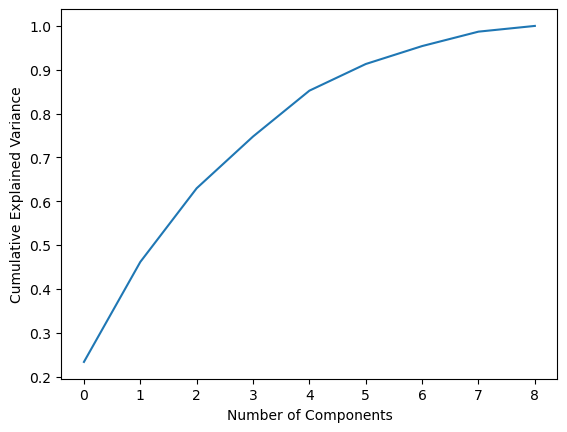

In [21]:
#Check how many Principal Components explain variance within the dataset

#import PCA and standard scaler
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler as SS

#define and scale the features
X = np.array(df.drop(columns=['individual', 'overall_in','overall_numeric', 'HID']))
y = np.array(df['MIVI'])
ss = SS()
X = ss.fit_transform(X)

#calculate explained variance for each PC
pca = PCA()
pca.fit_transform(X)
explained_variance = pca.explained_variance_ratio_

#plot cumulative variance for each PC
plt.plot(np.cumsum(explained_variance))
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.show()

#plot does not show definitive elbow, suggesting all/most PCs should be used in ML

In [22]:
# Try first without outliers

idx = tempdf["Dist_Floodplain"] > 1200 
tempdf = tempdf.drop(tempdf[idx].index) #get rid of outlier far from floodplain 

from sklearn.linear_model import LogisticRegression as LR
from sklearn.preprocessing import StandardScaler as SS
from sklearn.decomposition import PCA

X = np.array(tempdf.drop(columns=['individual', 'overall_in','overall_numeric', 'HID']))
y = np.array(tempdf['MIVI'])

Xtrain,Xtest,ytrain,ytest = tts(X,y,test_size=0.4) #test size of 0.2 yielded better results, but K-fold with k=5 did not

#scale data features
ss = SS()
Xtrain = ss.fit_transform(Xtrain)
Xtest = ss.transform(Xtest)

#all PCs necessary because of variance of all features accounting for MIVI invasion
# PC = PCA(n_components = 2)
# Xtrain = PC.fit_transform(Xtrain)
# Xtest = PC.transform(Xtest)

log = LR(solver = 'liblinear')
log.fit(Xtrain,ytrain)
y_pred = log.predict(Xtest)
print(log.score(Xtest, ytest))

matrix = compare_classes(y_pred, ytest)
matrix

0.6428571428571429
Test accuracy = 0.64


(Predicted  0  1  2  3  4
 Actual                  
 1          1  1  0  0  0
 2          0  1  1  0  0
 3          0  0  1  4  1
 4          0  0  1  0  3,
 0.6428571428571429)

In [23]:
#For MIVI, more samples might be better

X = np.array(df.drop(columns=['individual', 'overall_in','overall_numeric', 'HID']))
y = np.array(df['MIVI'])

Xtrain,Xtest,ytrain,ytest = tts(X,y,test_size=0.4)

ss = SS()
Xtrain = ss.fit_transform(Xtrain)
Xtest = ss.transform(Xtest)

#all PCs necessary because of variance of all features accounting for MIVI invasion

log = LR(solver = 'liblinear')
log.fit(Xtrain,ytrain)
y_pred = log.predict(Xtest)
print(log.score(Xtest, ytest))

matrix = compare_classes(y_pred, ytest)
matrix

#more samples typically perform better for MIVI as target

0.5217391304347826
Test accuracy = 0.52


(Predicted  0  1  2  3  4
 Actual                  
 1          1  0  0  0  0
 2          0  3  1  1  0
 3          0  0  2  6  1
 4          0  0  0  3  5,
 0.5217391304347826)

In [24]:
#Try RFC

from sklearn.ensemble import RandomForestClassifier as RFC
X = np.array(df.drop(columns=['individual', 'overall_in','overall_numeric', 'HID']))
y = np.array(df['MIVI'])

Xtrain,Xtest,ytrain,ytest = tts(X,y,test_size=0.4)

#all PCs necessary because of variance of all features accounting for MIVI invasion

rfc = RFC() 
rfc.fit(Xtrain,ytrain)
y_pred = rfc.predict(Xtest)
print(rfc.score(Xtest, ytest))

matrix = compare_classes(y_pred, ytest)
matrix

#performs much better, will optimize RFC params

0.8260869565217391
Test accuracy = 0.83


(Predicted  0  1  2  3  4
 Actual                  
 1          2  1  1  0  0
 2          0  1  5  0  0
 3          0  0  0  7  0
 4          0  0  0  0  6,
 0.8260869565217391)

# RFC determine best hyperparams

In [25]:
min_samples_range = np.arange(2, 11)
max_depth_range = np.arange(2, 11)
columns = ['min_samples_range', 'max_depth_range', 'accuracy']
scores = pd.DataFrame(columns = columns)
for s in min_samples_range:
    for m in max_depth_range:
        rfc = RFC(min_samples_split = s, max_depth = m)
        train_scores,test_scores = do_Kfold(rfc,X,y,5)
        new_row = {'min_samples_range': s,'max_depth_range': m, 'accuracy': np.mean(np.array(test_scores))}
        scores = pd.concat([scores, pd.DataFrame(new_row, index=[0])], ignore_index=True)

In [26]:
scores.loc[scores['accuracy'].idxmax(),:]

# min_samples_range           2
# max_depth_range             8
# accuracy             0.928788
# Name: 6, dtype: object

# min_samples_range           4
# max_depth_range             9
# accuracy             0.912121
# Name: 25, dtype: object

# min_samples_range           3
# max_depth_range             4
# accuracy             0.928788

# min_samples_range           2
# max_depth_range             5
# accuracy             0.928788

# min_samples_range           2
# max_depth_range             8
# accuracy             0.928788

# consistently between 2-4, 5-9 respectively

min_samples_range           2
max_depth_range             9
accuracy             0.928788
Name: 7, dtype: object

In [27]:
# narrower range, add more params
n_est_range = np.arange(1,11) * 10
min_samples_range = np.arange(2, 5)
max_depth_range = np.arange(5, 10)
columns = ['n_est_range','min_samples_range', 'max_depth_range', 'accuracy']
scores = pd.DataFrame(columns = columns)
for n in n_est_range:
    for s in min_samples_range:
        for m in max_depth_range:
            rfc = RFC(n, min_samples_split = s, max_depth = m)
            train_scores,test_scores = do_Kfold(rfc,X,y,5)
            new_row = {'n_est_range': n,'min_samples_range': s,'max_depth_range': m, 'accuracy': np.mean(np.array(test_scores))}
            scores = pd.concat([scores, pd.DataFrame(new_row, index=[0])], ignore_index=True)

In [28]:
scores.loc[scores['accuracy'].idxmax(),:]
#50
#2
#8
#0.92

# n_est_range               50
# min_samples_range          4
# max_depth_range            7
# accuracy             0.94697

# n_est_range               10
# min_samples_range          3
# max_depth_range            9
# accuracy             0.94697

# n_est_range                10
# min_samples_range           4
# max_depth_range             7
# accuracy             0.965152
# Name: 12, dtype: object

# n_est_range                30
# min_samples_range           2
# max_depth_range             6
# accuracy             0.930303

# n_est_range                70
# min_samples_range           3
# max_depth_range             9
# accuracy             0.928788

# n_est_range               70
# min_samples_range          2
# max_depth_range            8
# accuracy             0.94697

# n_est_range               30
# min_samples_range          2
# max_depth_range            9
# accuracy             0.94697

# n_est_range               40
# min_samples_range          2
# max_depth_range            5
# accuracy             0.94697

#assume optimal min_samples to be 3
#assume max_depth to be 7
#n_est more vague, keep between 10-70

n_est_range                10
min_samples_range           3
max_depth_range             7
accuracy             0.928788
Name: 7, dtype: object

In [29]:
# set fixed params, add min_samples_leaf
n_est_range = np.arange(1,8) * 10
s = 3 #set min_samples
m = 7 #set max_depth
min_samples_leaf_range = np.arange(1,11)
columns = ['n_est_range','min_samples_leaf_range', 'accuracy']
scores = pd.DataFrame(columns = columns)
for n in n_est_range:
    for l in min_samples_leaf_range:
        rfc = RFC(n, min_samples_split = s, max_depth = m, min_samples_leaf = l)
        train_scores,test_scores = do_Kfold(rfc,X,y,5, random_state = 146)
        new_row = {'n_est': n,'min_samples_leaf': l,'accuracy': np.mean(np.array(test_scores))}
        scores = pd.concat([scores, pd.DataFrame(new_row, index=[0])], ignore_index=True)

In [30]:
scores.loc[scores['accuracy'].idxmax(),:]

# accuracy                  0.910606
# n_est                         40.0
# min_samples_leaf               1.0

# accuracy                  0.910606
# n_est                         40.0
# min_samples_leaf               1.0
#min_samples_leaf performs best at 1 (default) 

# n_est_range                    NaN
# min_samples_leaf_range         NaN
# accuracy                  0.912121
# n_est                         50.0
# min_samples_leaf               1.0

np.mean(np.array(scores['accuracy'])) #avg accuracy of all iterations of tested parameters significantly decreases due to 
#less robust trees with high values of min_samples_leaf

0.710995670995671

In [31]:
#figure out n_est with set params
n_est_range = np.arange(1,8) * 10
s = 3 #set min_samples
m = 7 #set max_depth
l = 1 #set min_samples_leaf (default)
columns = ['n_est', 'accuracy']
scores = pd.DataFrame(columns = columns)
for n in n_est_range:
    rfc = RFC(n, min_samples_split = s, max_depth = m)
    train_scores,test_scores = do_Kfold(rfc,X,y,5, random_state = 146)
    new_row = {'n_est': n,'accuracy': np.mean(np.array(test_scores))}
    scores = pd.concat([scores, pd.DataFrame(new_row, index=[0])], ignore_index=True)

In [32]:
print(scores.loc[scores['accuracy'].idxmax(),:])

# accuracy                  0.94697
# n_est                        70.0

# n_est             20
# accuracy    0.948485

# n_est            20
# accuracy    0.94697

# n_est             40
# accuracy    0.910606

# n_est             30
# accuracy    0.928788

# n_est             30
# accuracy    0.912121

np.mean(np.array(scores['accuracy'])) #avg accuracy with set min_samples_leaf (and min_samples split and max_depth) again increases overall accuracy to high 80%

#refine n_est range to between 20-40 to increase runtime

n_est             20
accuracy    0.910606
Name: 1, dtype: object


0.8727272727272727

In [33]:
#refined n_est range
n_est_range = np.arange(2,5) * 10
s = 3 #set min_samples
m = 7 #set max_depth
columns = ['n_est', 'accuracy']
scores = pd.DataFrame(columns = columns)
for n in n_est_range:
    rfc = RFC(n, min_samples_split = s, max_depth = m)
    train_scores,test_scores = do_Kfold(rfc,X,y,5, random_state = 146)
    new_row = {'n_est': n,'accuracy': np.mean(np.array(test_scores))}
    scores = pd.concat([scores, pd.DataFrame(new_row, index=[0])], ignore_index=True)

In [34]:

# n_est             40
# accuracy    0.910606

# n_est             40
# accuracy    0.892424

np.mean(np.array(scores['accuracy'])) 
scores

#consistently shows 30 or 40 n_est as most optimal for highest accuracy 
#in the interest of preventing overfitting for future prediction outside of train/test data,
#n_est = 30 

,n_est,accuracy
0,20,0.874242
1,30,0.840909
2,40,0.842424


# Optimized RFC 
shows k-fold average accuracies in mid to high 80s

In [35]:
from sklearn.ensemble import RandomForestClassifier as RFC
from sklearn.model_selection import train_test_split as tts

X = np.array(df.drop(columns=['individual', 'overall_in','overall_numeric', 'HID']))
y = np.array(df['MIVI'])

Xtrain,Xtest,ytrain,ytest = tts(X,y,test_size=0.4, random_state = 146)

#all PCs necessary because of variance of all features accounting for MIVI invasion

rfc = RFC(30, min_samples_split = s, max_depth = m, random_state = 146) #min_samples_leaf is set to default
rfc.fit(Xtrain,ytrain)
y_pred = rfc.predict(Xtest)
print(rfc.score(Xtest, ytest))

matrix = compare_classes(y_pred, ytest)
matrix    

0.8695652173913043
Test accuracy = 0.87


(Predicted  1  2   3  4
 Actual                
 1          0  1   0  0
 2          1  5   0  0
 3          0  0  10  1
 4          0  0   0  5,
 0.8695652173913043)